In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('.')
sys.path.append('./scripts')
from competing_methods_local import *
from simulations_util import *
from util import  apply_splitting_strategy
from sklearn.preprocessing import StandardScaler

/accounts/projects/binyu/zhongyuan_liang/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'lightgrey'

### Classification

In [ ]:
task = "classification" 
datasets = ["openml_43", "openml_361062", "openml_361071", "openml_9978", "openml_361069", "openml_361068", "openml_361063"]
combined_df = pd.DataFrame()
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    split_seeds = [1,2,3,4,5]
    rf_seeds = [1,2,3]
    for split_seed in split_seeds:
        for rf_seed in rf_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)

# remove fi is Local_MDI+_MDI_lasso_fit_on_all_ranking_RFPlus or Local_MDI+_MDI_ridge_fit_on_all_ranking_RFPlus
combined_df = combined_df[~(
    (combined_df["fi"] == "Local_MDI+_MDI_lasso_fit_on_all_ranking_RFPlus") |
    (combined_df["fi"] == "Local_MDI+_MDI_ridge_fit_on_all_ranking_RFPlus")
)]

In [4]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

data_name = {
    "openml_43": "Spam",
    "openml_9946": "Breast Cancer",
    "openml_9978": "Ozone",
    "openml_146819": "Climate",
    "openml_361062": "Pol",
    "openml_361070": "Eye Movement"
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
}

/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


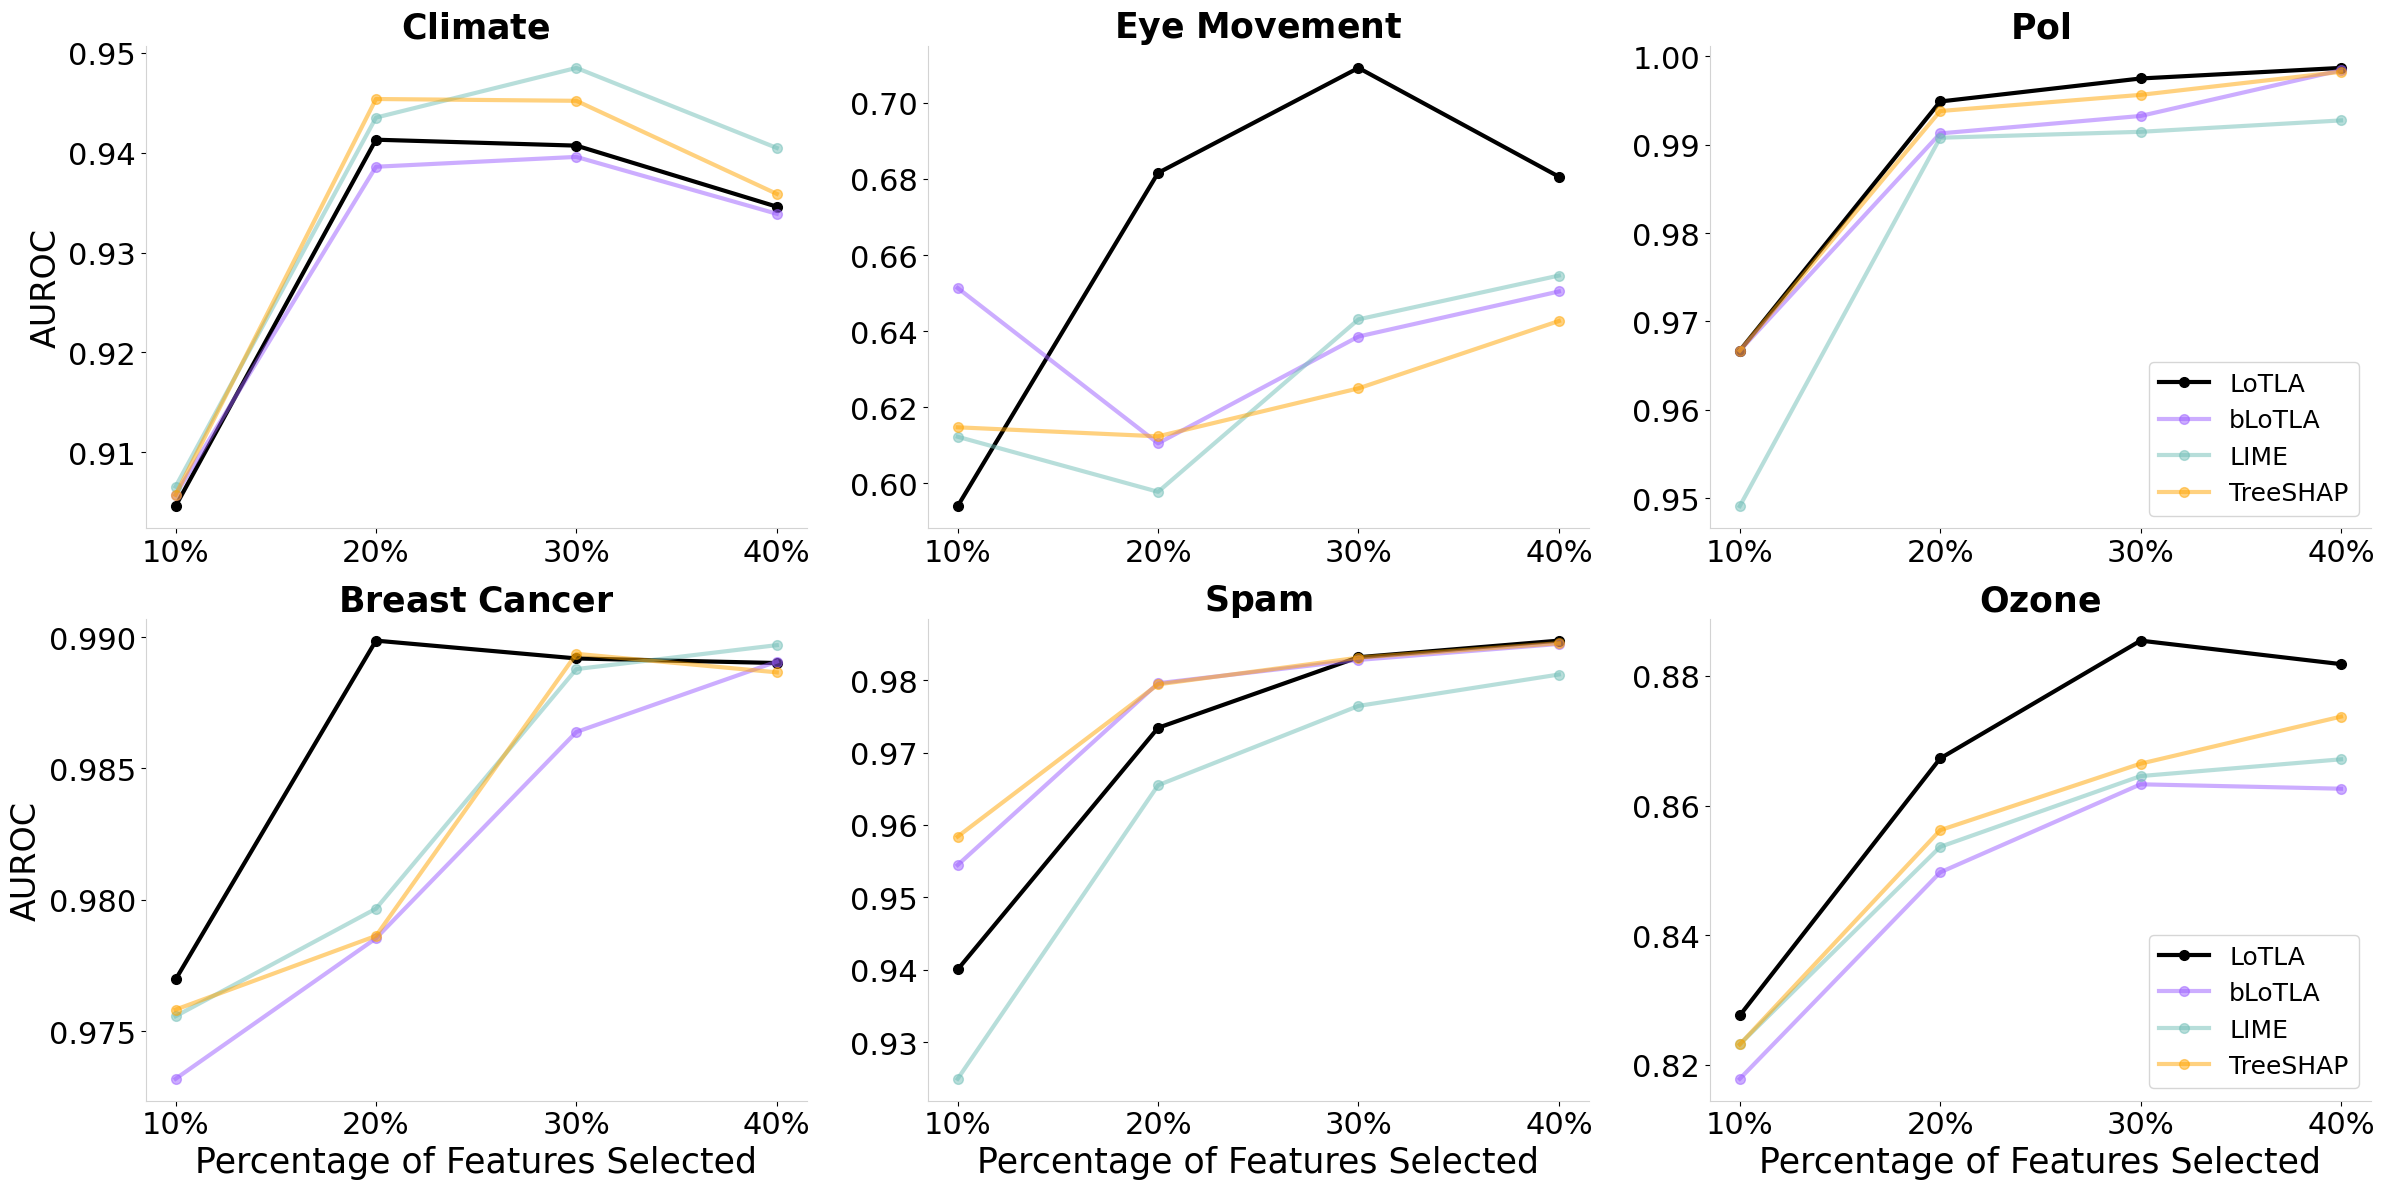

In [5]:
df = combined_df
datasets = df["data"].unique()

marker_size = 7
dotted_methods = ['LIME_RF', 'TreeSHAP_RF', 'MDI']  # This is retained in case you need it later

# Determine number of rows and columns
n_cols = 3
n_rows = 2#len(datasets) // n_cols

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    sharey=False
)

# Flatten axes for easier indexing
axs = axs.flatten()

# Loop through each dataset
for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    subset = df[df["data"] == dataset]
    
    # Plot results for each method
    for method in methods:
        method_data = subset[subset["fi"] == method]
        results = method_data[
            ["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]
        ].mean(axis=0).values
        
        if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4], results,
                label=methods_name[method], linestyle='solid',  # Only dotted lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
            )
        else:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4], results,
                label=methods_name[method], linestyle='solid',  # Only solid lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3
            )
    
    # Set x-axis and labels
    ax.set_xticks([0.1, 0.2, 0.3, 0.4])
    ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=22)
    ax.tick_params(axis='y', labelsize=22)    
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel("Percentage of Features Selected", fontsize=25)
    
    # Only set y-axis label for the first plot in each row
    if idx % n_cols == 0:
        ax.set_ylabel("AUROC", fontsize=24)
    else:
        ax.set_ylabel("")
    
    # Set subplot title
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=25)
    
    # Add legend to the last plot in each row
    if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
        ax.legend(fontsize=18, loc='lower right')

plt.tight_layout(rect=[0, 0, 1, 1])
# Add a title at the top
plt.savefig("feature_selection_classification.png")
plt.show()


In [6]:
df_summary = df.groupby(['fi', 'data'])[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].mean().reset_index()
columns_to_rank = ['RF_Classifier_AUROC_top_0.1', 'RF_Classifier_AUROC_top_0.2', 
                   'RF_Classifier_AUROC_top_0.3', 'RF_Classifier_AUROC_top_0.4']
rank_results_classification = pd.DataFrame()
for data in datasets:
    df_data = df_summary[df_summary["data"] == data]
    ranked_df = df_data.copy()
    for col in columns_to_rank:
        ranked_df[col] = df_data[col].rank(ascending=False, method='min')
    rank_results_classification = pd.concat([rank_results_classification, ranked_df], ignore_index=True)

#rename columns
rank_results_classification.columns = ['fi', 'data', 'top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']

### Regression

In [ ]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ["openml_361622", "openml_361260", "openml_361259", "openml_361253", "openml_361254", "openml_361242", "openml_361243"]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    split_seeds = [1,2,3,4,5]
    rf_seeds = [1,2,3]
    for split_seed in split_seeds:
        for rf_seed in rf_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)

In [9]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

data_name = {
    "openml_361260": "Miami Housing",
    "openml_361622": "Cars",
    "openml_361254": "SARCOS",
    "openml_361259": "Puma Robot",
    "openml_361253": "Wave Energy",
    "openml_361242": "Super Conductivitity"
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
}

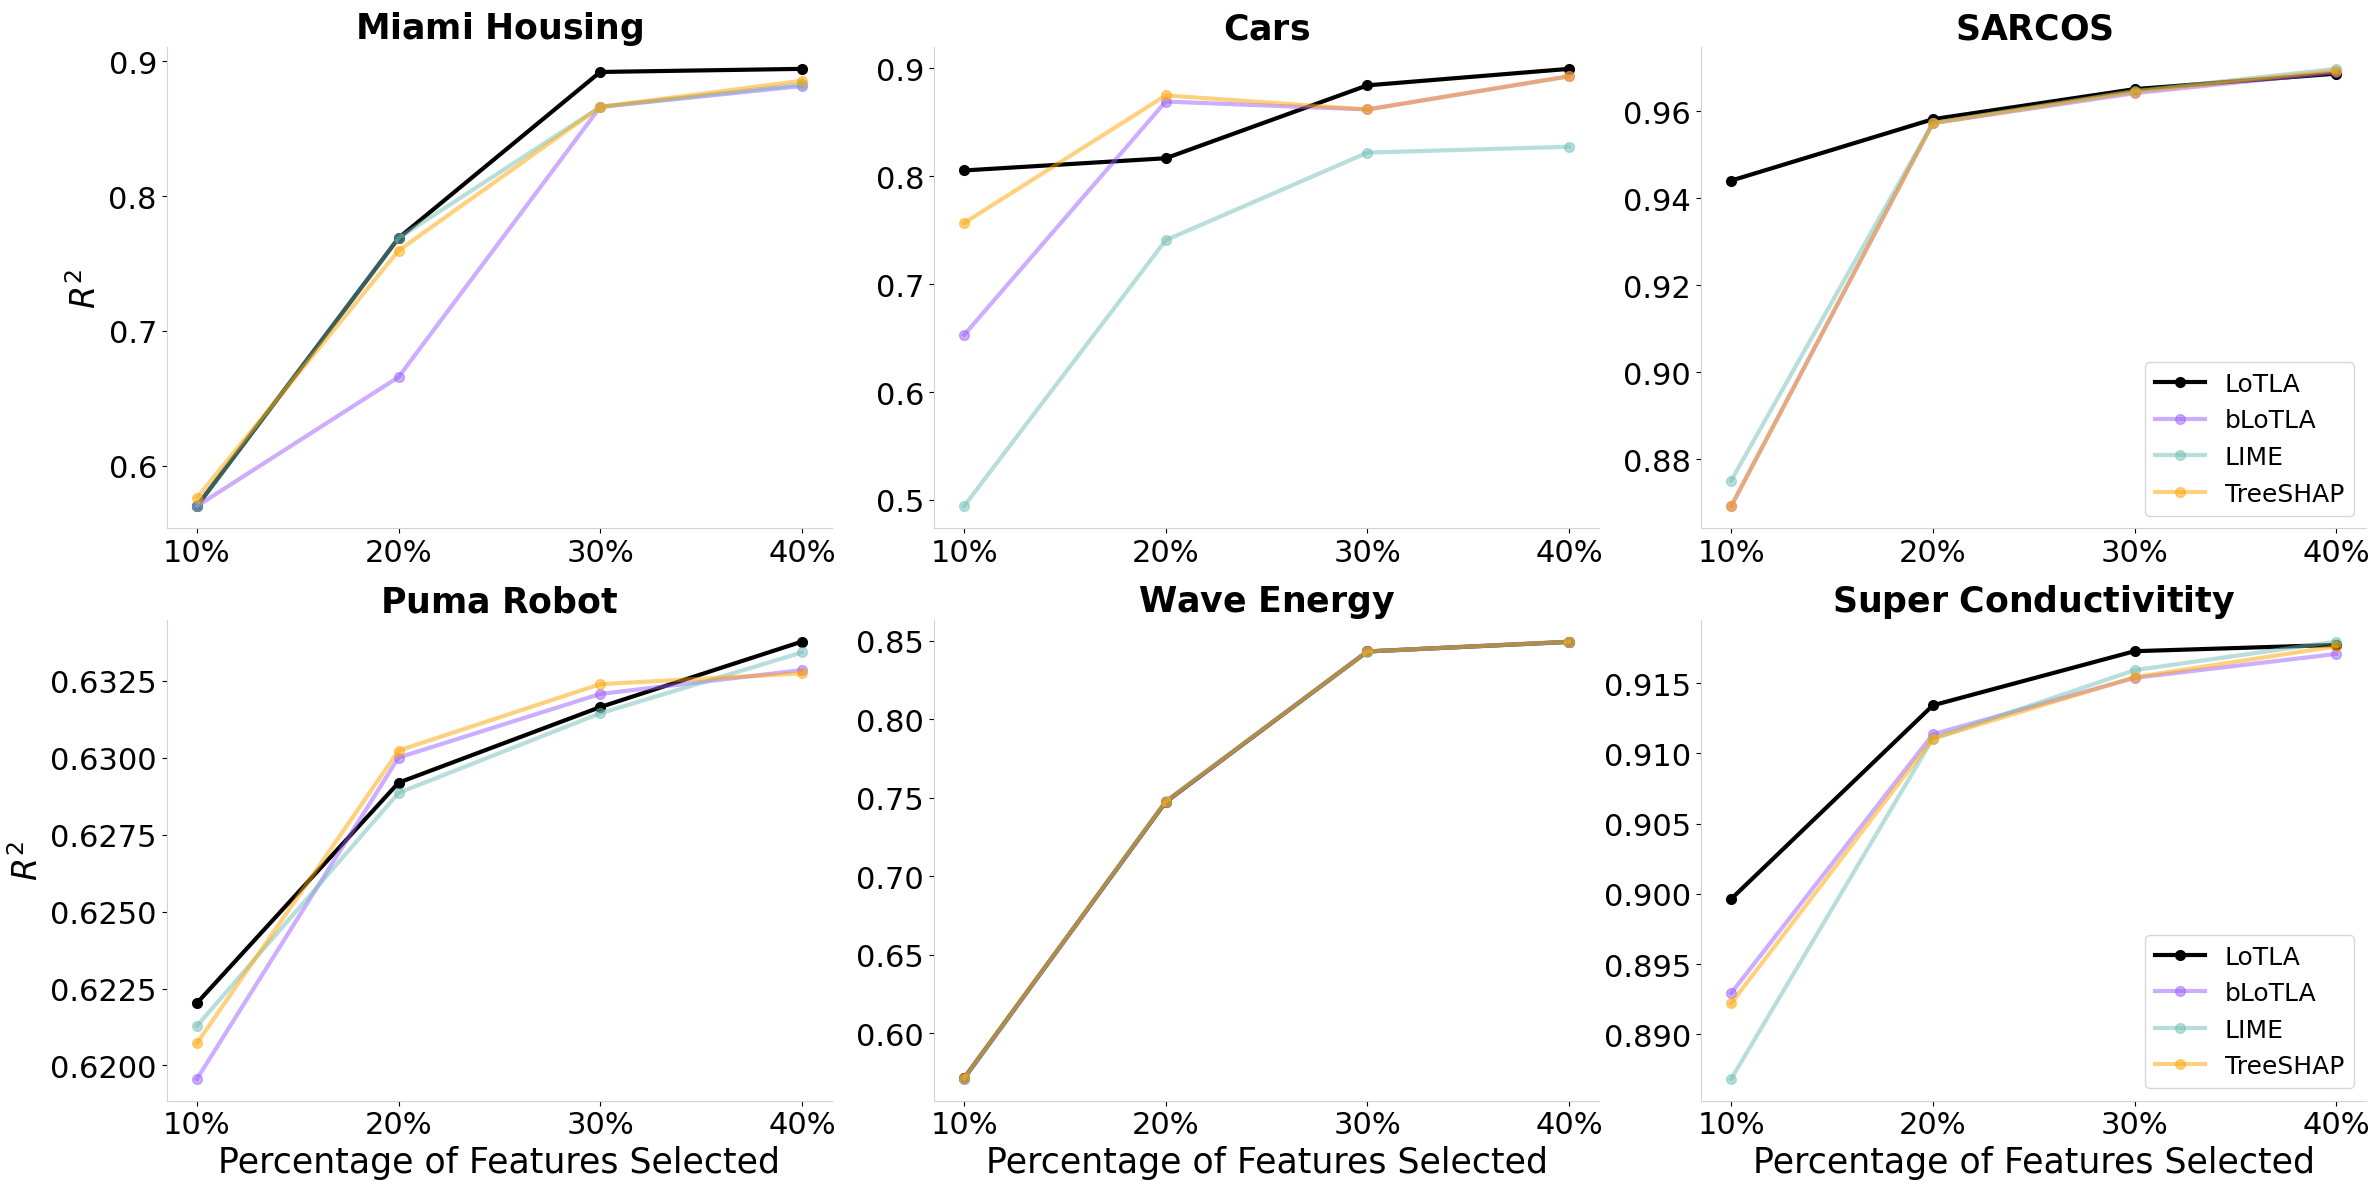

In [10]:
df = combined_df
datasets = df["data"].unique()

marker_size = 7

# Determine number of rows and columns
n_cols = 3
n_rows = 2  # len(datasets) // n_cols

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    sharey=False
)

# Flatten axes for easier indexing
axs = axs.flatten()

# Loop through each dataset
for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    subset = df[df["data"] == dataset]
    
    # Plot results for each method
    for method in methods:
        method_data = subset[subset["fi"] == method]
        results = method_data[
            ["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]
        ].mean(axis=0).values
        
        if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4], results,
                label=methods_name[method], linestyle='solid',  # Only solid lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
            )
        else:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4], results,
                label=methods_name[method], linestyle='solid',  # Only solid lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3
            )
    
    # Set x-axis and labels
    ax.set_xticks([0.1, 0.2, 0.3, 0.4])
    ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=22)
    ax.tick_params(axis='y', labelsize=22)
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel("Percentage of Features Selected", fontsize=25)
    
    # Only set y-axis label for the first plot in each row
    if idx % n_cols == 0:
        ax.set_ylabel(r"$R^2$", fontsize=24)
    else:
        ax.set_ylabel("")
    
    # Set subplot title
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=25)
    
    # Add legend to the last plot in each row
    if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
        ax.legend(fontsize=18, loc='lower right')

# Adjust layout and show plot
plt.tight_layout(rect=[0.01, 0, 1, 1])
# Add a title at the top
plt.savefig("feature_selection_regression.png")
plt.show()

In [11]:
df_summary = df.groupby(['fi', 'data'])[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].mean().reset_index()
columns_to_rank = ["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]
rank_results_regression = pd.DataFrame()
for data in datasets:
    df_data = df_summary[df_summary["data"] == data]
    ranked_df = df_data.copy()
    for col in columns_to_rank:
        ranked_df[col] = df_data[col].rank(ascending=False, method='min')
    rank_results_regression = pd.concat([rank_results_regression, ranked_df], ignore_index=True)
rank_results_regression.columns = ['fi', 'data', 'top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']

In [12]:
rank_results = pd.concat([rank_results_classification, rank_results_regression], ignore_index=True)
rank_results.groupby('fi')[['top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']].mean().sort_values(by='top_0.1')

,top_0.1,top_0.2,top_0.3,top_0.4
fi,,,,
Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus,2.000000,1.916667,1.500000,1.833333
TreeSHAP_RF,2.000000,2.166667,2.333333,2.666667
MDI,2.666667,2.916667,3.166667,3.000000
LIME_RF,2.916667,2.916667,3.000000,2.500000
